# Assignment 3
### Importing images, rescaling, and forming a dataset

In [1]:
import os
import numpy as np
from sklearn import decomposition
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

IMG_SZ = (200, 200)
DATA_SZ = 500
n_components = 10

class Dataset:
    data = []
    targets = []
    
labels = {
    'jersey': 0,
    'shirt': 1
}

dataset = Dataset()

for lbl in labels:
    for image in os.listdir('img/' + lbl)[:int(DATA_SZ / 2)]:
        cur_img = Image.open('img/' + lbl + '/' + image).resize(IMG_SZ)
        dataset.data.append(np.array(cur_img).flatten())
        dataset.targets.append(labels[lbl])
dataset.data = np.array(dataset.data)
dataset.targets = np.array(dataset.targets)

### Function for restoring and visualizing images

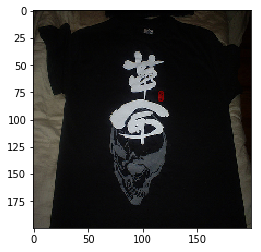

In [93]:
def imviz(nparr, mean=[None]):
    if mean[0] != None:
        nparr = (nparr + mean).astype('uint8')
    PIL_img = Image.fromarray(nparr.reshape(IMG_SZ[0], IMG_SZ[1], 3))
    plt.imshow(PIL_img)
        
imviz(dataset.data[0]) # testing

### Normalizing images

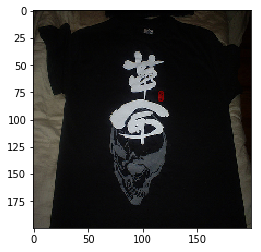

In [94]:
mean = dataset.data.mean(axis=0)

X = dataset.data - mean
y = dataset.targets

imviz(X[0], mean) # testing

### Splitting into train and test sets, initilizating SVM classifiers

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import svm

TEST_SZ = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SZ, random_state=42)

clf_orig = svm.LinearSVC()
clf_pca = svm.LinearSVC()
clf_lda = svm.LinearSVC()

### Training and testing on original pixel data

In [5]:
clf_orig.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [109]:
print("Accuracy on train set:", clf_orig.score(X_train, y_train))
print("Accuracy on test set:", clf_orig.score(X_test, y_test))

Accuracy on train set: 0.9925
Accuracy on test set: 0.52


### Training and testing on PCA-representation of data

In [7]:
from sklearn import decomposition

n_components = 10

pca = decomposition.PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

Explained variance of components: [0.33192429 0.15308218 0.04598221 0.03339894 0.02610347 0.02472668
 0.02111701 0.0144963  0.01302523 0.01038103]


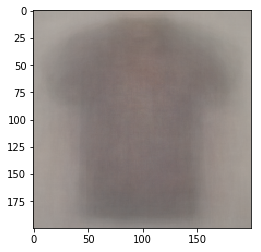

In [116]:
print("Explained variance of components:", pca.explained_variance_ratio_) # how much information is retained
imviz(pca.components_[0], mean) # visualize one of the components

In [9]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca[0]) # making sure it has coordinates of n components

[ 0.54896176 -0.05290471  1.25553493 -0.16518802 -1.04363254  0.22003516
 -0.33438401 -1.19718676 -0.30369945 -0.59129889]


### Visualizing the SVD (restored from PCA) of an example jersey

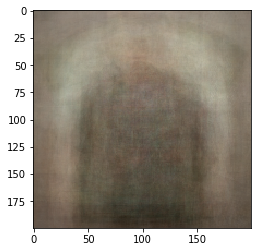

In [102]:
# Searching for the first jersey
idx = 0
while y_train[idx] != 0:
    idx += 1

svd_jersey = pca.inverse_transform(X_train_pca[idx])
imviz(svd_jersey, mean) # wow haha

Something dark and no sleves?

### Visualizing the SVD (restored from PCA) of an example shirt

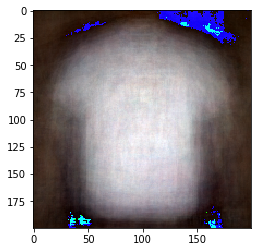

In [104]:
# Searching for the first shirt
idx = 0
while y_train[idx] != 1:
    idx += 1

svd_shirt = pca.inverse_transform(X_train_pca[idx])
imviz(svd_shirt, mean) # wow haha

Something white with sleeves?

In [10]:
clf_pca.fit(X_train_pca, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [108]:
print("Accuracy on train set:", clf_pca.score(X_train_pca, y_train))
print("Accuracy on test set:", clf_pca.score(X_test_pca, y_test))

Accuracy on train set: 0.6075
Accuracy on test set: 0.59


### Training and testing on LDA-representation of data

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=n_components, solver='svd')
lda.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [13]:
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train_lda[0]) # making sure it has 1 coordinate (since we have 2 classes => 1 LDA component)

[-8.04220602]


Explained variance of component: [1.]


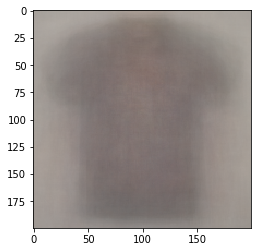

In [19]:
print("Explained variance of component:", lda.explained_variance_ratio_) # how much information is retained
imviz(lda.coef_, mean) # visualize one of the components

In [23]:
print(lda.coef_)
print(pca.components_[0])

[[0.00076895 0.00021736 0.00044057 ... 0.00078318 0.0005666  0.00038751]]
[-0.00419957 -0.0044604  -0.00458189 ... -0.00445883 -0.00475282
 -0.00490834]


LDA and PCA components are not equal!

In [105]:
clf_lda.fit(X_train_lda, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [107]:
print("Accuracy on train set:", clf_lda.score(X_train_lda, y_train))
print("Accuracy on test set:", clf_lda.score(X_test_lda, y_test))

Accuracy on train set: 0.9925
Accuracy on test set: 0.5


### Conclusions
As we can see, in order of descdending accuracy, first place is classification on PCA, then original data, and then LDA. In this case, LDA performed poorly because it only provides on discriminant component (since there are only 2 classes), meaning, although we're finding the projection that shows maximum separability, we are losing too much information about the 200x200x3 dimensional space. When comparing the outputs of LDA and PCA, we can see that although they are different, they are actually similar when we consider that the range for each pixel is 0-255. Thus, PCA's first component has similar predictive power as LDA's only component but then PCA has more components to cover for other interesting regions, unlike LDA which is limited to only one. Also, LDA assumes that our data points are normally distributed whereas it is not likely the case here, for example, because shirts are mostly white (thus, we would have skewed distribution of values of pixels somewhere in the center where the shirt is).

The SVM classifier performed better on PCA than on original reasons. I think, there are two reasons for this. First of all, as we can see, the SVM trained on original data does not converge (through gradient descent), meaning, that it is not in the global optimum, unlike PCA's SVM. Then, the one that has converged has a minimized loss function, thus, has higher accuracy. The second reason (theoretically speaking) is that in PCA, we reduce the dimension of the space (from 200x200x3 to 10 in this case. This way, we are able to come up with a few features that retain a good amount of variance thus not losing too much information about original data. Having fewer features means that we will less likely overfit since chance noise would be ignored when projected onto direction of maximum variance (we can observed that train set accuracy for full-dimensional data is super high whereas for PCA it's more reserved). Therefore, we should get a better accuracy on test set.

To conclude, in high dimensional problems like this, PCA, although an unsupervised algorithm, seems to be a good practice to perform before fitting a classifier because we will reduce the dimension while retaining the "interesting" features (and reduce chance noise in the data). This means, we will be able to avoid high-variance when fitting a classifier. On the other hand, in binary classificatino LDA offers at most 1 discriminant component, and it can be helpful to understand what is the factor that separates data the most (e.g., shirts tend to be white while jerseys tend to be dark color).